In [33]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def fit_line_to_image(img):
    data = np.copy(img)
    nb_rows, nb_cols = data.shape
    x_data, y_data = [], []
    for i in range(nb_cols):
        column = data[:,i]
        maxi = max(column)
        y = np.where(column != maxi)[0]
        y_data.extend(y.tolist())
        x_data.extend([i] * len(y))
    z = np.polyfit(x_data, y_data, deg=1)
    p = np.poly1d(z)
    return p

In [35]:
def get_angle(x1,x2,y1,y2):
    if x1 == x2:
        return 0
    m = (y2-y1)/(x2-x1)
    # tan(alpha) = |m1-m2/1+m1*m2|
    angle = np.degrees(np.arctan(m))
    return round(angle, 2)

In [36]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [37]:
def fill_outer_whites(img):
    ## (1) Convert to gray, and threshold
    th, threshed = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV)

    ## (2) Morph-op to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    ## (3) Fill in the outer white spaces of the image with black
    mask = cv2.bitwise_not(morphed)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)

    new_img = cv2.subtract(img,mask)
    return new_img

In [40]:
data_folder_path = r'D:\Proiecte\AI\armd\data\raw\02_oct\02_Kermany\experiment'
file_paths = list(Path(data_folder_path).glob('*\*'))[:20]

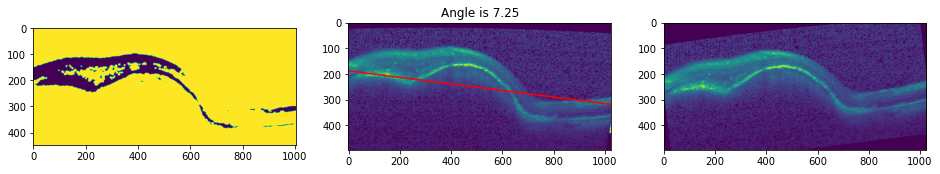

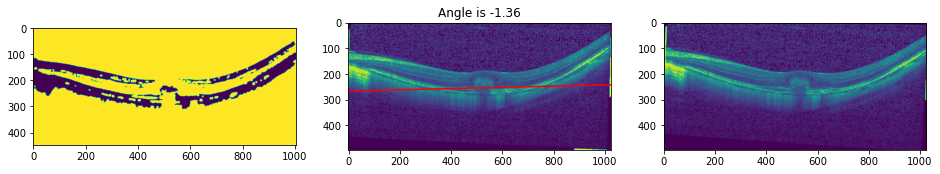

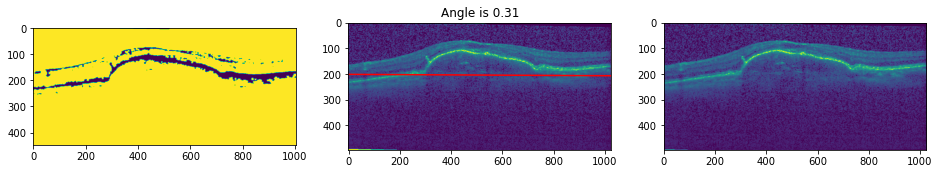

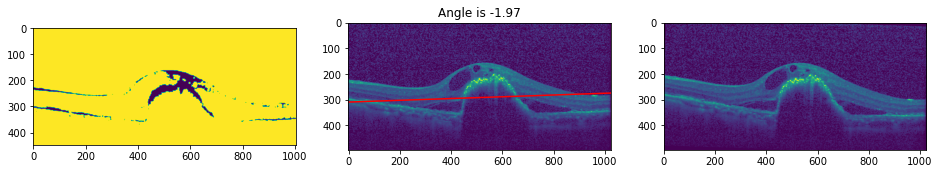

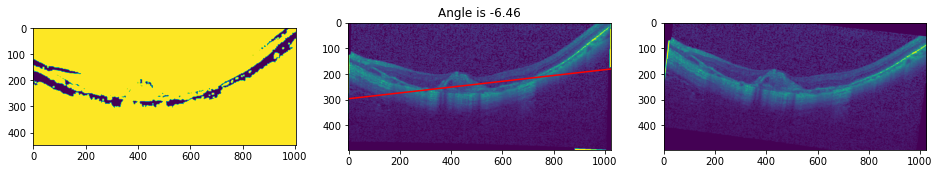

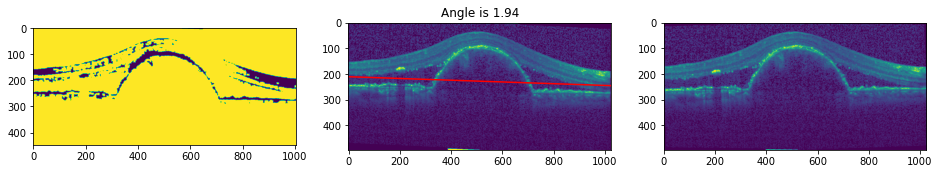

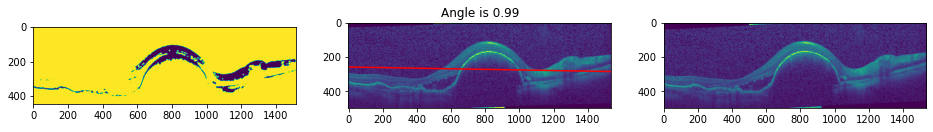

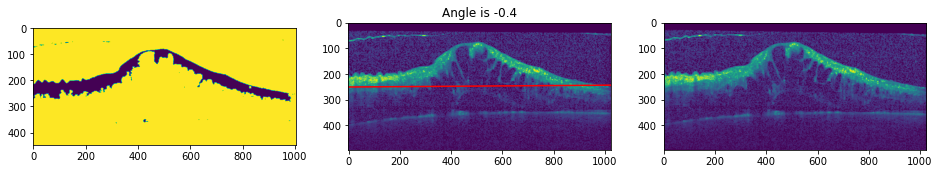

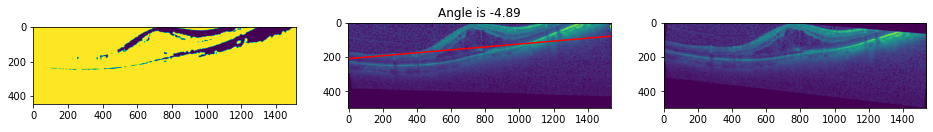

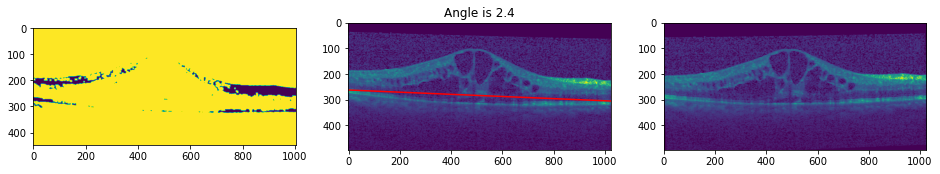

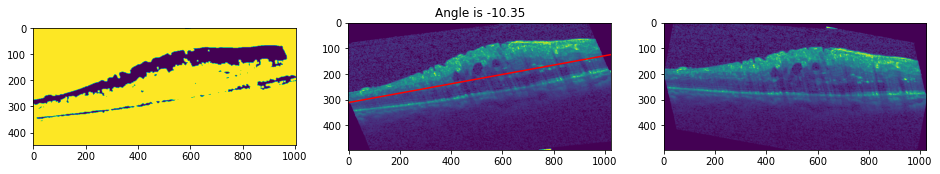

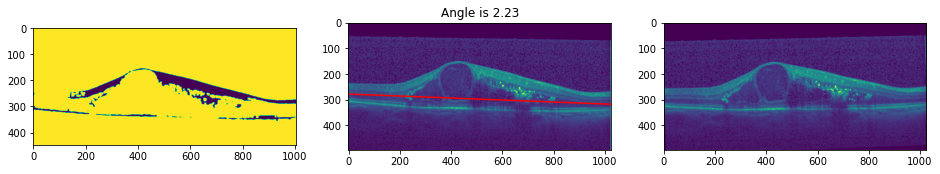

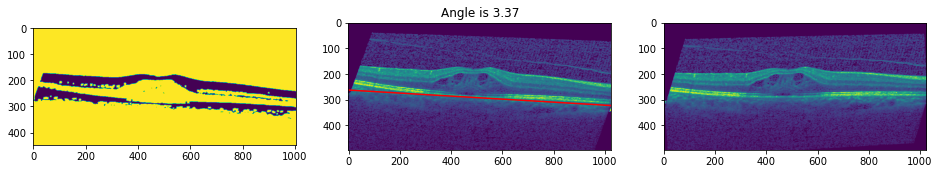

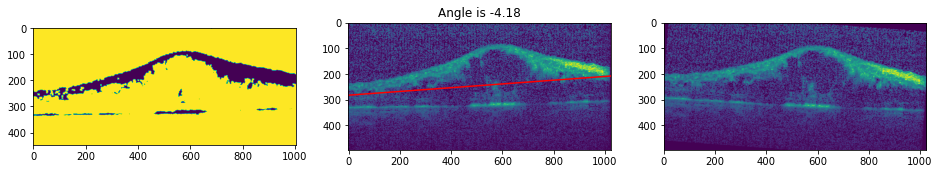

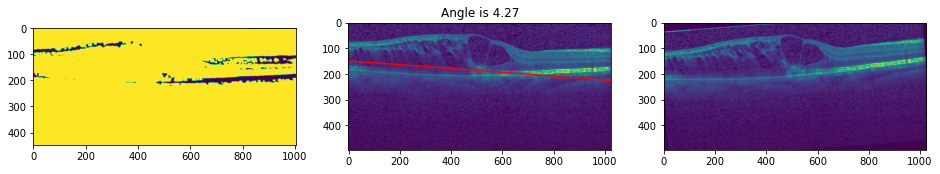

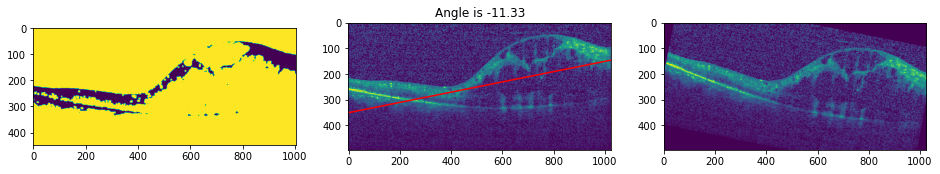

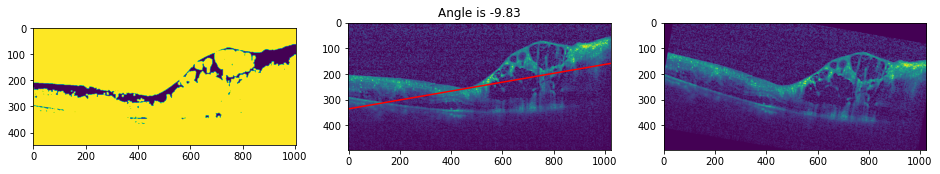

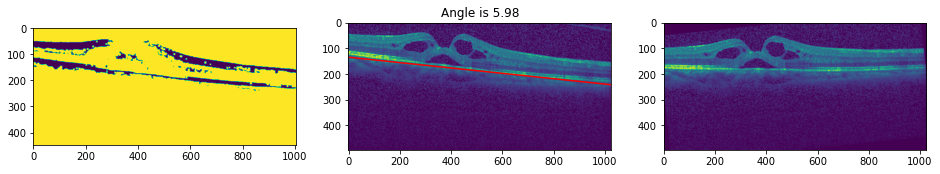

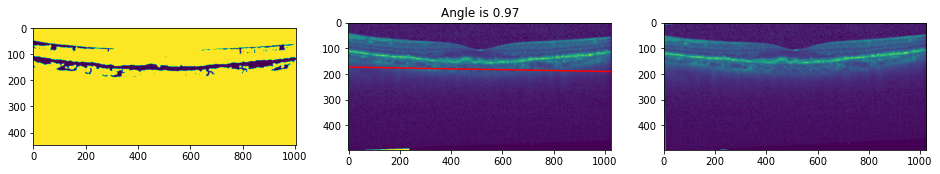

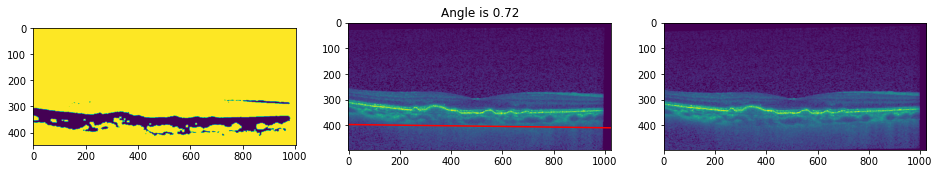

In [41]:
for file_path in file_paths:
    img_org = cv2.imread(str(file_path), 0)
    
    img = fill_outer_whites(img_org)
    
    th, threshed = cv2.threshold(img, 85, 150, cv2.THRESH_BINARY_INV)
    threshed = threshed[:-50, 10:-10]
    
    blured = cv2.medianBlur(threshed,5)

    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(blured,kernel,iterations = 2)
    
    line_func = fit_line_to_image(dilation)
    x_data = np.arange(0, img.shape[1])
    y_data = line_func(x_data) + 50
    
    angle = get_angle(*x_data[:2],*y_data[:2])
    rot_img = rotate(img, angle)
    
    fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(16,5))
    ax0.imshow(dilation)
    ax1.imshow(img)
    ax1.plot(x_data, y_data, color='red')
    ax1.set_title(f'Angle is {angle}')
    ax2.imshow(rot_img)
    plt.show()

#     low_th = 15
#     low_hi = 35
#     edges = cv2.Canny(img,low_th,low_hi)

#     kernel = np.ones((5,5),np.uint8)
#     opening = cv2.dilate(edges,kernel,iterations = 2)

#     img_cpy = np.copy(img)
#     contours = cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
#     for contour in sorted(contours, key=cv2.contourArea, reverse=True)[:1]:
#         rect = cv2.minAreaRect(contour)
#         box = cv2.boxPoints(rect).astype(int)
#         img_cpy = cv2.drawContours(img_cpy,[box],0,(0,255,255),3)
    
#     fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(16,5))
#     ax0.imshow(edges)
#     ax1.imshow(opening)    
#     ax2.imshow(img_cpy)    